In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 下载和加载MNIST数据集
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# 创建数据加载器
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# 下载和加载MNIST数据集
test_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# 创建数据加载器
test_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)


100%|██████████| 9912422/9912422 [00:00<00:00, 111249779.23it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29969246.37it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30509087.12it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13368792.12it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
# 定义简单的卷积神经网络模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 初始化模型、损失函数和优化器
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/10], Loss: 0.1584, Accuracy: 95.12%
Epoch [2/10], Loss: 0.0458, Accuracy: 98.56%
Epoch [3/10], Loss: 0.0309, Accuracy: 98.98%
Epoch [4/10], Loss: 0.0214, Accuracy: 99.33%
Epoch [5/10], Loss: 0.0175, Accuracy: 99.46%
Epoch [6/10], Loss: 0.0144, Accuracy: 99.50%
Epoch [7/10], Loss: 0.0111, Accuracy: 99.62%
Epoch [8/10], Loss: 0.0091, Accuracy: 99.70%
Epoch [9/10], Loss: 0.0073, Accuracy: 99.74%
Epoch [10/10], Loss: 0.0084, Accuracy: 99.72%


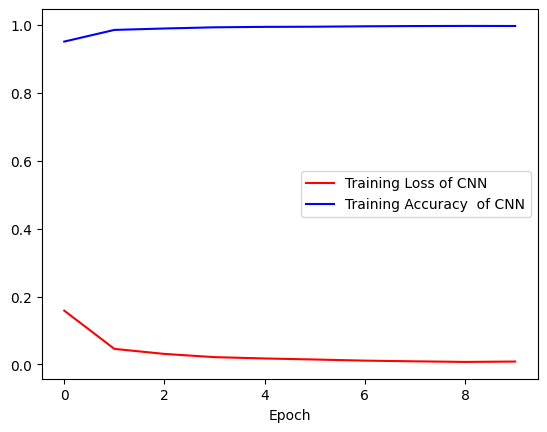

In [4]:
# 记录训练损失和准确度的列表
train_losses = []
train_accuracies = []

# 训练模型
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 统计训练损失
        running_loss += loss.item()

        # 统计训练准确度
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # 计算平均训练损失
    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)

    # 计算训练准确度
    accuracy = correct_predictions / total_samples
    train_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

# 绘制学习曲线，使用明显的颜色
plt.plot(train_losses, label='Training Loss of CNN', color='r')
plt.plot(train_accuracies, label='Training Accuracy  of CNN', color='b')

# 添加图例
plt.legend()

# 显示图形
plt.xlabel('Epoch')
plt.show()


In [5]:
from torchsummary import summary

# 打印模型结构和参数数量
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 64, 14, 14]          18,496
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Linear-5                  [-1, 128]         401,536
            Linear-6                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 1.61
Estimated Total Size (MB): 1.97
----------------------------------------------------------------


In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 在测试集上进行预测
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

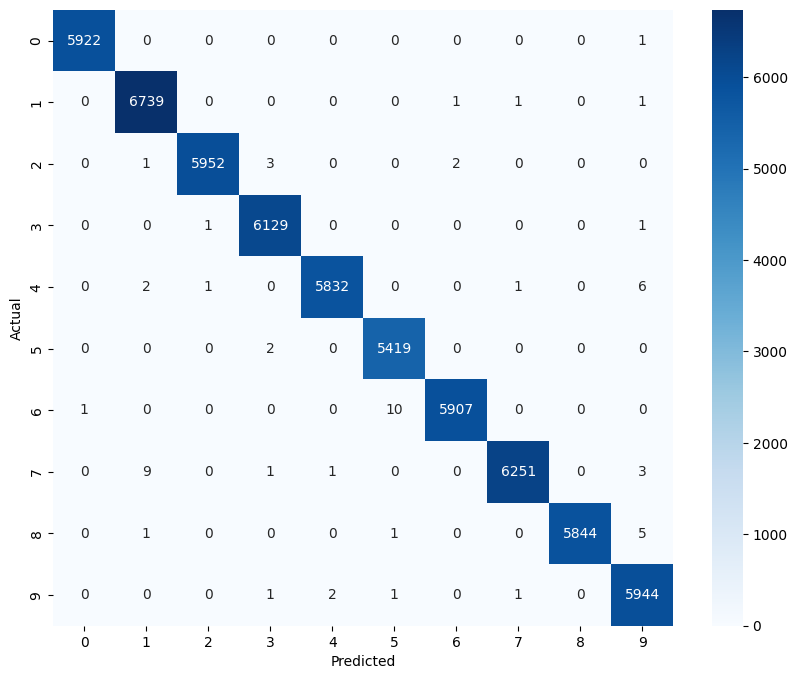

In [7]:
# 生成混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 使用seaborn绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [8]:
from sklearn.metrics import f1_score

# 假设 all_preds 是预测标签，all_labels 是真实标签
# 计算 Macro-averaging 的 F1-score
macro_f1 = f1_score(all_labels, all_preds, average='macro')
print(f'Macro-averaging F1-score: {macro_f1:.4f}')

# 计算 Micro-averaging 的 F1-score
micro_f1 = f1_score(all_labels, all_preds, average='micro')
print(f'Micro-averaging F1-score: {micro_f1:.4f}')

# 计算每个类别的 F1-score
per_class_f1 = f1_score(all_labels, all_preds, average=None)
print('Per-class F1-score:')
for i, f1 in enumerate(per_class_f1):
    print(f'Class {i}: {f1:.4f}')


Macro-averaging F1-score: 0.9990
Micro-averaging F1-score: 0.9990
Per-class F1-score:
Class 0: 0.9998
Class 1: 0.9988
Class 2: 0.9993
Class 3: 0.9993
Class 4: 0.9989
Class 5: 0.9987
Class 6: 0.9988
Class 7: 0.9986
Class 8: 0.9994
Class 9: 0.9982


In [9]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9990
